################################################################################

**Author**: _Pradip Kumar Das_

**License:** https://github.com/PradipKumarDas/Competitions/blob/main/LICENSE

**Profile & Contact:** [LinkedIn](https://www.linkedin.com/in/daspradipkumar/) | [GitHub](https://github.com/PradipKumarDas) | [Kaggle](https://www.kaggle.com/pradipkumardas) | pradipkumardas@hotmail.com (Email)

################################################################################

# **CommonLit Readability Assessment**

## Determinining Baseline Performance with 1D ConvNet with Pre-trained Word Embeddings

In [2]:
# Imports required packages

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Some initialization

sns.set_theme()

### Loading Data & Counting Samples

In [4]:
# Loads data

train = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
submission = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

In [5]:
# Checks how the data looks from top few samples

display(train.head())

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


## Data Preparation

In [6]:
# Making all excerpts in lowercase

train.excerpt = train.excerpt.str.lower()

### Segmenting (Discrete Interval) Label

As the distribution of labels are not equal, the labels should be splitted with stratification so that each fold get nearly equal distribution from data segments. 

In [7]:
# Sets configurations

n_bins = 20
n_splits = 5

In [8]:
# Segments discrete interval of label by marking each sample with a bin number

train["bin"] = pd.cut(x=train.target, bins=n_bins, labels=[i for i in range(n_bins)])

In [9]:
# Ensurs interval of each bin is near to equal

display(train.groupby(["bin"]).target.apply(lambda x: x.max()-x.min()))

bin
0     0.262752
1     0.260542
2     0.263781
3     0.265146
4     0.260765
5     0.267405
6     0.262840
7     0.267969
8     0.268411
9     0.267741
10    0.268120
11    0.266945
12    0.266250
13    0.263739
14    0.265295
15    0.263889
16    0.263011
17    0.217768
18    0.261957
19    0.267005
Name: target, dtype: float64

In [10]:
# Creates K-Fold cross validator

k_fold_cv= StratifiedKFold(n_splits=n_splits, shuffle=True)

validation_scores = []    # Stores validation scores across folds
test_predictions = np.zeros(shape=(len(submission), n_splits))

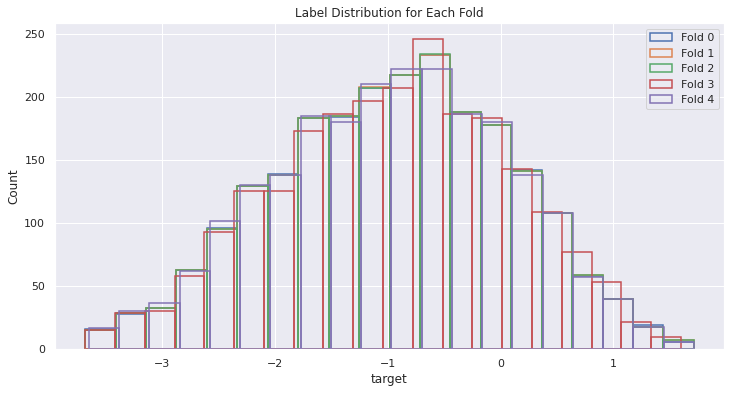

In [11]:
# Create K-Fold cross validation splitter

k_fold_cv_generator = k_fold_cv.split(train, y=train.bin)

# Plots to verify if every split gets equal distribution of samples from every bin

plt.figure(figsize=(12, 6))

for fold, (id_x_train, id_x_val) in enumerate(k_fold_cv_generator):
    sns.histplot(data=train.iloc[id_x_train], x="target", bins=n_bins, fill=False, label=f"Fold {fold}")

plt.title('Label Distribution for Each Fold')
plt.legend()
plt.show()

In [12]:
# Removes columns considered not to be required

train.drop(["url_legal", "license"], axis=1, inplace=True)
test.drop(["url_legal", "license"], axis=1, inplace=True)

## Configurations

In [13]:
max_features = 30000    # Vocabulary size was little more than 30000 found during analysis
max_length = 250        # Considering a little more than 205 found during analysis
embedding_dim = 300     # 300 dimensional GloVe word embedding is being considered
batch_size = 32         # Size of the batch of samples to take as input at a time during model training
epochs = 20             # Number of epochs to train model

## Modeling

In [14]:
# Creates vectorizer
vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=max_length)

In [15]:
# Extracts and loads vectors from GloVe word embeddings

embeddings_index = {}

with open("../input/glove6b/glove.6B.300d.txt") as file:
    for i, line in enumerate(file):
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embeddings_index[word] = coefs

Fold 0...
	Number of missing words in Glove: 3800
	Training model... completed.
	RMSE over validation data: 0.990170755982399

	Performing Prediction on fold 0... done.

Fold 1...
	Number of missing words in Glove: 3692
	Training model... completed.
	RMSE over validation data: 0.9329379975795746

	Performing Prediction on fold 1... done.

Fold 2...
	Number of missing words in Glove: 3741
	Training model... completed.
	RMSE over validation data: 0.9616937339305878

	Performing Prediction on fold 2... done.

Fold 3...
	Number of missing words in Glove: 3758
	Training model... completed.
	RMSE over validation data: 0.9236085712909698

	Performing Prediction on fold 3... done.

Fold 4...
	Number of missing words in Glove: 3714
	Training model... completed.
	RMSE over validation data: 0.9312028557062149

	Performing Prediction on fold 4... done.

K-Fold cross validation RMSE performance: 0.9468755134127356


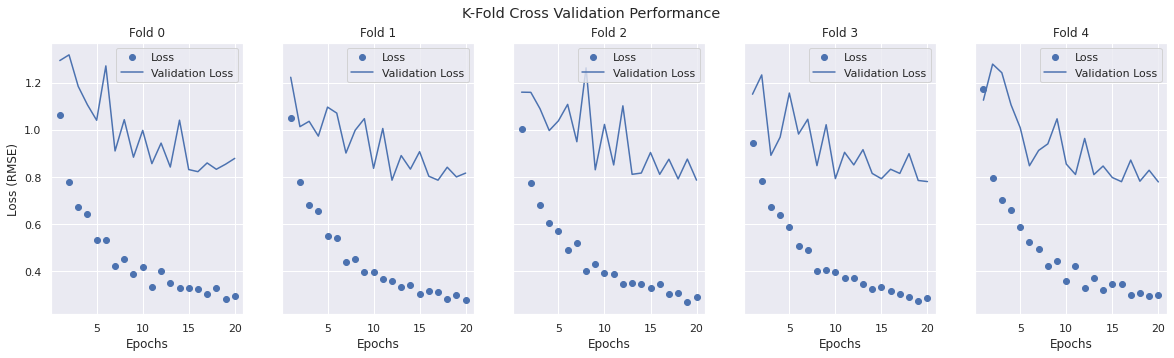

In [18]:
fig, axes = plt.subplots(1, n_splits, sharex=True, sharey=True, figsize=(20, 5))
fig.suptitle("K-Fold Cross Validation Performance")

k_fold_cv_generator = k_fold_cv.split(train, y=train.bin)

# Iterates over each fold to train the linear regression model, 
# predict on validation data and stores into a list to get its mean at the end

for fold, (idx_train, idx_val) in enumerate(k_fold_cv_generator):
    print(f"Fold {fold}...")

    text_ds = tf.data.Dataset.from_tensor_slices(train.excerpt.iloc[idx_train]).batch(32)
    vectorizer.adapt(text_ds)
    
    voc = vectorizer.get_vocabulary()
    word_index = dict(zip(voc, range(len(voc))))
    
    missing_words_in_pretrained_embeddings = 0
    embeddings_matrix = np.zeros((max_features, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector
        else:
            missing_words_in_pretrained_embeddings += 1
    print(f"\tNumber of missing words in Glove: {missing_words_in_pretrained_embeddings}")
    
    embedding_layer = layers.Embedding(max_features, 
                                   embedding_dim, 
                                   embeddings_initializer=keras.initializers.Constant(embeddings_matrix),
                                   input_length=max_length, 
                                   trainable=False)
    
    sequences_input = layers.Input(shape=(None,), dtype="int64")
    x = embedding_layer(sequences_input)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(128, activation="relu")(x)
    #x = layers.Dropout(0.1)(x)
    predictions_output = layers.Dense(1)(x)

    model = keras.Model(sequences_input, predictions_output)
    
    x_train = vectorizer(np.array([[s] for s in train.excerpt.iloc[idx_train]])).numpy()
    x_val = vectorizer(np.array([[s] for s in train.excerpt.iloc[idx_val]])).numpy()

    y_train = np.array(train.target.iloc[idx_train])
    y_val = np.array(train.target.iloc[idx_val])
    
    print("\tTraining model...", end=" ")
    model.compile(optimizer="rmsprop", loss= "mse", metrics=[RootMeanSquaredError()])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                        verbose=False, shuffle=False, validation_data=(x_val, y_val))
    print("completed.")
    
    history = history.history
    
    axes[fold].set_title(f"Fold {fold}")
    axes[fold].plot(range(1, len(history["root_mean_squared_error"]) + 1), history["root_mean_squared_error"], "bo", label="Loss")
    axes[fold].plot(range(1, len(history["val_root_mean_squared_error"]) + 1), history["val_root_mean_squared_error"], "b", label="Validation Loss")
    axes[fold].set_xlabel("Epochs")
    if fold == 0:
        axes[fold].set_ylabel("Loss (RMSE)")
    axes[fold].legend()
    
    rmse = np.mean(history["val_root_mean_squared_error"])
    validation_scores.append(rmse)
    print(f"\tRMSE over validation data: {rmse}")
    # Performs predictions on test data
    print(f"\tPerforming predictions on fold {fold}...", end=" ")
    x_test = vectorizer(np.array([[s] for s in test.excerpt])).numpy()
    predictions = model.predict(x_test)
    predictions.resize((len(test)))
    test_predictions[:,fold] = predictions.copy()
    print("done.")
    print()
    
print(f"K-Fold cross validation RMSE performance: {np.mean(validation_scores)}")

## Submission

In [27]:
# Averaging predictions across folds

submission.target = test_predictions.mean(axis=1)

In [30]:
# Submitting by saving predictions into submission file

submission.to_csv("submission.csv", index=False)